<hr/>
<hr/>
<hr/>

In [16]:
import flopy
import flopy.utils.binaryfile as bf
import json, rasterio
import fiona
#import geopandas as gpd
import numpy as np
from shapely.geometry import LineString
from tqdm import tqdm
import time

#open input files
jsonFile = open('../txt/disvDict.json', 'r')
disvDict = json.load(jsonFile)

jsonFile = open('../txt/spatialIndexDict.json', 'r')
spatialIndexDict = json.load(jsonFile)

demRaster = rasterio.open('../rst/ASTGTM2_18S_xyz2.asc')
#riversDf =  gpd.read_file('../shps/rios.shp')
riverList = fiona.open('../shps/rios.shp')
#meshDf = gpd.read_file('../shps/voronoiGridRelaxed.shp')
meshList = fiona.open('../shps/voronoiGridRelaxed.shp')

### MODFLOW Model ###
modelName = 'Model'
workSpace = '../model'
exeName = '../exe/mf6.exe'


In [17]:
sim = flopy.mf6.MFSimulation(sim_name=modelName, version='mf6',
                             exe_name=exeName,
                             sim_ws=workSpace)

tdis = flopy.mf6.ModflowTdis(sim, time_units='SECONDS',
                             perioddata=[[1.0, 1, 1.]])

gwf = flopy.mf6.ModflowGwf(sim, modelname=modelName, save_flows=True)

ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='complex',
                           outer_hclose=1.e-2, inner_hclose=1.e-2)

#data from dictionary
cell2d = disvDict['cell2dArrays']
vertices = disvDict['indexedVerticesList']
ncpl = disvDict['NCPL']
nvert = disvDict['NVERT']
#another disv data
thickRatio = [0.05,0.1,0.2,0.4,0.7,1]
nlay = 6
bot = 3200

top = []

layBotmList = []
for cell in cell2d:
    cellBotmList = []
    cellCentroid = cell[1:3]
    valuesXY = demRaster.sample([cellCentroid])
    topCell = float(list(valuesXY)[0][0])
    top.append(topCell)
    for lay in range(nlay):
        botm = bot + (topCell - bot)*(1-thickRatio[lay])
        cellBotmList.append(botm)
    layBotmList.append(cellBotmList)

topArray = np.array(top)
botm = np.array(layBotmList).T

dis = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, nvert=nvert,
                               top=topArray, botm=botm,
                               vertices=vertices, cell2d=cell2d)

# Flujo de propiedad
kh = [1E-4, 1E-4, 5E-5, 1E-6, 5E-7, 5E-7]
icelltype = [1, 1, 1, 1, 0, 0]
npf = flopy.mf6.ModflowGwfnpf(gwf,
                              save_specific_discharge=True,
                              icelltype=icelltype,
                              k=kh,
                              k33=kh)

ic = flopy.mf6.ModflowGwfic(gwf, strt=topArray.max())

rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.15/86400/365)

evt = flopy.mf6.ModflowGwfevta(gwf, surface=top, rate=1.2/86400/365)

# Get grid index
intervalNumber = spatialIndexDict['intervalNumber']
gridXarray = spatialIndexDict['gridXarray']
gridYarray = spatialIndexDict['gridYarray']
gridIndexList = spatialIndexDict['gridIndexList']

#defining function
def findIndex(var, coordArray):
    for interval in range(intervalNumber):
        if var > coordArray[interval] and var < coordArray[interval+1]:
            return interval
            break

In [18]:
print('\nWorking with the spatial index of rivers')
riverCellsList = []
riverSpd = []

riversDf[["xInterBeg","xInterEnd","yInterBeg","yInterEnd"]] = 0
for riverIndex, riverRow in tqdm(riversDf.iterrows(), total= riversDf.shape[0]):
    coords = riverRow.geometry.bounds
    xmin = coords[0]
    xmax = coords[2]
    ymin = coords[1]
    ymax = coords[3]
    xInterBeg = findIndex(xmin,gridXarray)
    xInterEnd = findIndex(xmax,gridXarray)
    yInterBeg = findIndex(ymin,gridYarray)
    yInterEnd = findIndex(ymax,gridYarray)
    riversDf.loc[riverIndex,"xInterBeg"] = xInterBeg
    riversDf.loc[riverIndex,"xInterEnd"] = xInterEnd
    riversDf.loc[riverIndex,"yInterBeg"] = yInterBeg
    riversDf.loc[riverIndex,"yInterEnd"] = yInterEnd


Working with the spatial index of rivers


NameError: name 'riversDf' is not defined

<hr/>
<hr/>
<hr/>

In [40]:
import pyvista as pv
import numpy as np
from itkwidgets import view
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

In [44]:
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                   
                   [1.2, 0.2],[1.3, 0.3],[1.4, 0.4],[1.5, 0.5],
                   
                   [1.25, 0.5],[1.25, 0.6],[1.25, 0.7],

                   [2, 0], [2, 1], [2, 2]])


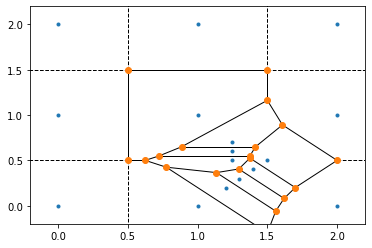

In [48]:
vor = Voronoi(points)
fig = voronoi_plot_2d(vor)
plt.show()

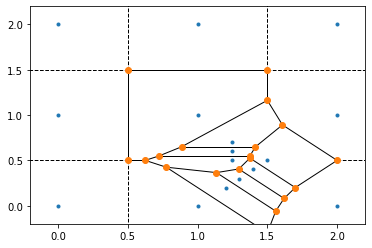

In [56]:

vor = Voronoi(points, qhull_options="Qbb Qc Qz Qx Q4")
fig = voronoi_plot_2d(vor)
plt.show()

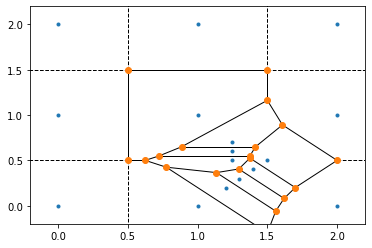

In [46]:
vor = Voronoi(points, incremental=False)
fig = voronoi_plot_2d(vor)
plt.show()